# COMP532 - Assignment 1 Code

- Pantelis Kasioulis | 201801753 | p.kasioulis@liverpool.ac.uk
- Ewa Fojcik | 201529790 | e.k.fojick@liverpool.ac.uk
- Gabriel Thomas Newton | 201855293 | g.newton2@liverpool.ac.uk
- Zoi Kallinaki | 201832458 | z.kallinaki@liverpool.ac.uk

### Importing Libraries and Setting Fixed Parameters:


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

np.random.seed(42)
n_arms = 10
n_steps = 2000
epsilons = [0, 0.01, 0.1]
n_experiments = 2000

### Multi-Armed Bandit and Epsilon-Greedy Implimentation:

In [5]:
class MultiArmedBandit:
    """ A class representing the n-armed bandit environment. """

    def __init__(self, n_arms=10):
        """ Initialize the n-armed bandit. """
        self.n_arms = n_arms
        self.true_values = np.random.normal(0, 1, n_arms)
        self.optimal_action = np.argmax(self.true_values)

    def pull(self, arm):
        """ Pull an arm and get a reward. """
        return np.random.normal(self.true_values[arm], 1)

class EpsilonGreedy:
    """ Epsilon-greedy algorithm for the multi-armed bandit problem. """
    def __init__(self, bandit, epsilon=0.1):
        """ Initialize the epsilon-greedy algorithm. """
        self.bandit = bandit
        self.epsilon = epsilon
        self.n_arms = bandit.n_arms
        self.action_values = np.zeros(self.n_arms)
        self.action_counts = np.zeros(self.n_arms)
        self.rewards = []
        self.actions = []

    def select_action(self):
        """ Select an action using epsilon-greedy policy. """
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        max_value = np.max(self.action_values)
        max_actions = np.where(self.action_values == max_value)[0]
        return np.random.choice(max_actions)

    def update(self, action, reward):
        """ Update action value estimates based on received reward. """
        self.action_counts[action] += 1
        n = self.action_counts[action]
        old_value = self.action_values[action]
        self.action_values[action] = old_value + (1/n) * (reward - old_value) # Q_n = Q_(n-1) + (1/n) * [R_n - Q_(n-1)]

    def run(self, n_steps=2000):
        """ Run the algorithm for n_steps. """
        optimal_actions = []
        regret = []
        cumulative_regret = 0
        optimal_value = np.max(self.bandit.true_values)
        for _ in tqdm(range(n_steps), desc=f"ε={self.epsilon}", disable=True):
            action = self.select_action()
            action_value = self.bandit.true_values[action]
            instantaneous_regret = optimal_value - action_value
            cumulative_regret += instantaneous_regret
            reward = self.bandit.pull(action)
            self.update(action, reward)
            self.rewards.append(reward)
            self.actions.append(action)
            optimal_actions.append(action == self.bandit.optimal_action)
            regret.append(cumulative_regret)

        return self.rewards, optimal_actions, regret

def run_single_experiment(args):
    """ Run a single experiment for one bandit problem. """
    seed, n_arms, n_steps, epsilons = args
    np.random.seed(seed)
    results = {
        'rewards': {},
        'optimal_actions': {},
        'regret': {}
    }
    bandit = MultiArmedBandit(n_arms)
    for eps in epsilons:
        algorithm = EpsilonGreedy(bandit, epsilon=eps)
        rewards, optimal_actions, regret = algorithm.run(n_steps)
        results['rewards'][eps] = rewards
        results['optimal_actions'][eps] = optimal_actions
        results['regret'][eps] = regret

    return results

def run_experiment(n_arms=10, n_steps=2000, epsilons=[0, 0.01, 0.1], n_experiments=2000):
    """ Run multiple experiments and average the results. """
    seeds = np.random.randint(0, 10000, size=n_experiments)
    results_list = []
    for seed in tqdm(seeds, desc="Experiments"):
        results_list.append(run_single_experiment((seed, n_arms, n_steps, epsilons)))

    all_rewards = {eps: np.zeros((n_experiments, n_steps)) for eps in epsilons}
    all_optimal = {eps: np.zeros((n_experiments, n_steps)) for eps in epsilons}
    all_regret = {eps: np.zeros((n_experiments, n_steps)) for eps in epsilons}
    for i, results in enumerate(results_list):
        for eps in epsilons:
            all_rewards[eps][i, :] = results['rewards'][eps]
            all_optimal[eps][i, :] = results['optimal_actions'][eps]
            all_regret[eps][i, :] = results['regret'][eps]
    avg_rewards = {eps: np.mean(all_rewards[eps], axis=0) for eps in epsilons}
    pct_optimal = {eps: 100 * np.mean(all_optimal[eps], axis=0) for eps in epsilons}
    avg_regret = {eps: np.mean(all_regret[eps], axis=0) for eps in epsilons}

    return avg_rewards, pct_optimal, avg_regret



### Violin Plot for True Action Values and Reward Distributions (as done in Figure 2.1 in Sutton & Barto):

<ipython-input-6-f5519579c16a>:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


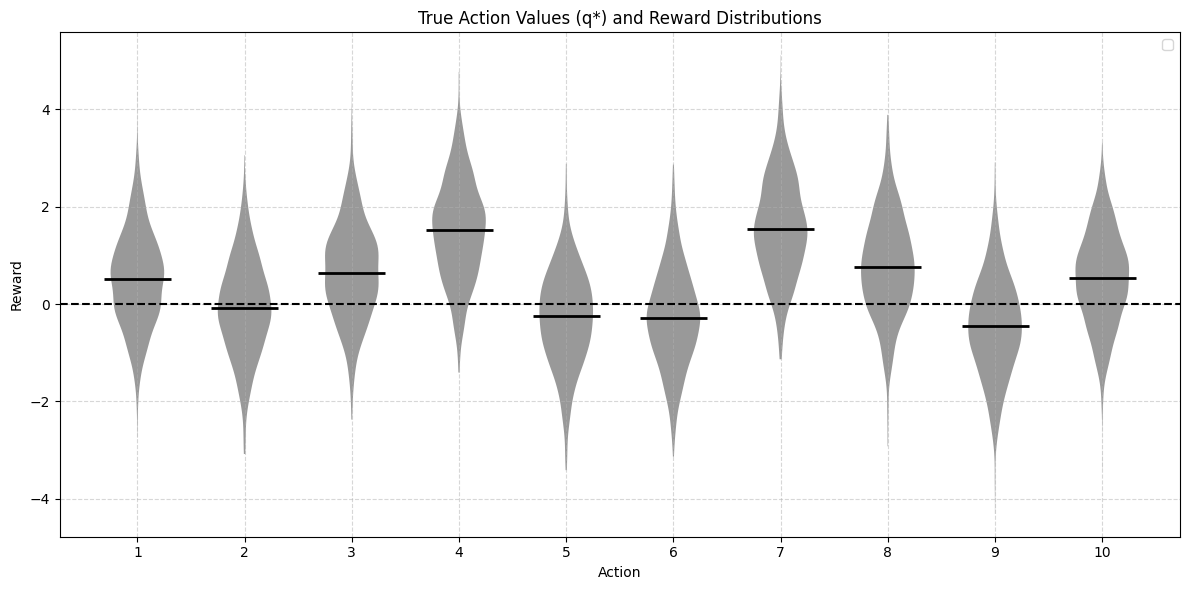

In [6]:
def plot_true_action_values(bandit):
    """ Violin plot similar to Figure 2.1 in Sutton & Barto. """
    plt.figure(figsize=(12, 6))

    n_samples = 1000
    samples = [
        np.random.normal(q, 1, n_samples)
        for q in bandit.true_values
    ]

    positions = np.arange(1, bandit.n_arms + 1)
    violin_parts = plt.violinplot(
        samples,
        positions=positions,
        showmeans=False,
        showmedians=True,
        showextrema=False
    )
    for pc in violin_parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_alpha(0.8)
    cmedians = violin_parts['cmedians']
    cmedians.set_linewidth(2)
    cmedians.set_color("black")

    scale_factor = 2.5
    for path in cmedians.get_paths():
        vertices = path.vertices.copy()
        if len(vertices) == 2:
            x0, y0 = vertices[0]
            x1, y1 = vertices[1]
            x_center = (x0 + x1) / 2
            new_length = (x1 - x0) * scale_factor
            vertices[0, 0] = x_center - new_length / 2
            vertices[1, 0] = x_center + new_length / 2
            path.vertices = vertices

    plt.title("True Action Values (q*) and Reward Distributions")
    plt.xlabel("Action")
    plt.ylabel("Reward")
    plt.axhline(0, linestyle="--", color="black")
    plt.xticks(positions)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

sample_bandit = MultiArmedBandit(n_arms)
plot_true_action_values(sample_bandit)

### Average Reward and Optimal Actions Graphs (as done in Figure 2.2 in Sutton & Barto):

In [ ]:
def plot_results(avg_rewards, pct_optimal, epsilons, n_arms):
    """ Plot results similar to Figure 2.2 in Sutton & Barto. """
    plt.figure(figsize=(12, 10))
    colors = ['green', 'red', 'blue']
    plt.subplot(2, 1, 1)
    for i, eps in enumerate(epsilons):
        cumulative_rewards = np.cumsum(avg_rewards[eps])
        steps = np.arange(1, len(cumulative_rewards) + 1)
        running_avg = cumulative_rewards / steps
        label = f'ε = {eps}' + (' (greedy)' if eps == 0 else '')
        plt.plot(steps, running_avg, label=label, color=colors[i])
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title(f'Average Reward over Time ({n_arms}-armed bandit)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.subplot(2, 1, 2)
    for i, eps in enumerate(epsilons):
        cumulative_optimal = np.cumsum(pct_optimal[eps])
        steps = np.arange(1, len(cumulative_optimal) + 1)
        running_pct = cumulative_optimal / steps
        label = f'ε = {eps}' + (' (greedy)' if eps == 0 else '')
        plt.plot(steps, running_pct, label=label, color=colors[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal Action')
    plt.title(f'Percentage of Optimal Actions ({n_arms}-armed bandit)')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

avg_rewards, pct_optimal, avg_regret = run_experiment(
    n_arms=n_arms,
    n_steps=n_steps,
    epsilons=epsilons,
    n_experiments=n_experiments
)

plot_results(avg_rewards, pct_optimal, epsilons, n_arms)


Experiments:  22%|██▏       | 434/2000 [01:48<05:35,  4.67it/s]

### Regret Graph Plot:

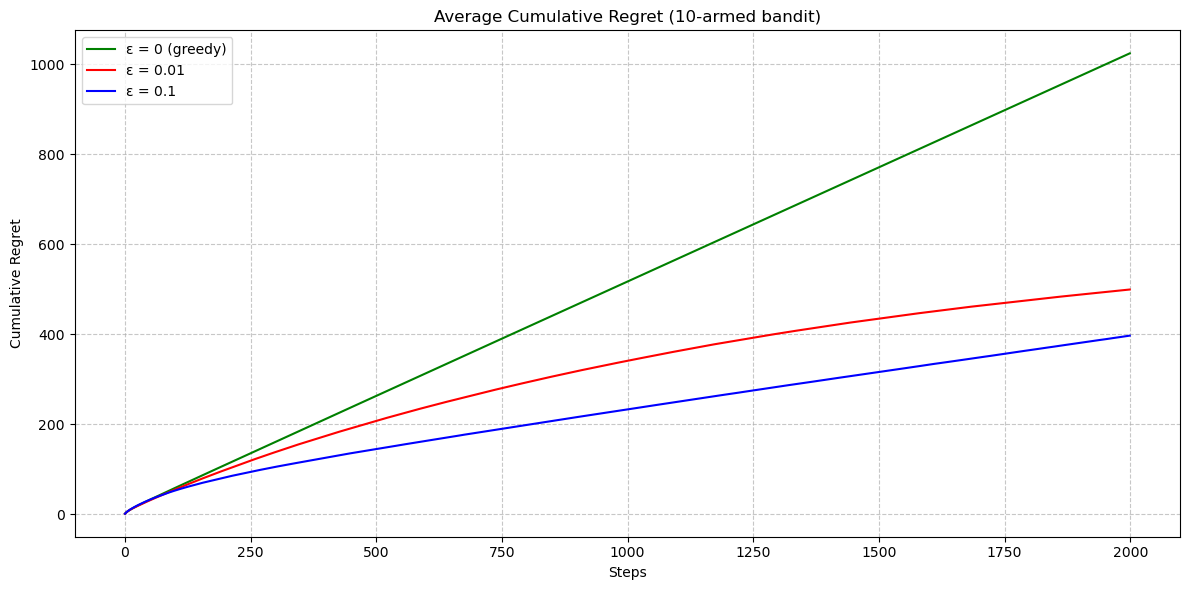

In [ ]:
def plot_regret(avg_regret, epsilons, n_arms):
    """ Plot average regret over time. """
    plt.figure(figsize=(12, 6))
    colors = ['green', 'red', 'blue']

    for i, eps in enumerate(epsilons):
        label = f'ε = {eps}' + (' (greedy)' if eps == 0 else '')
        plt.plot(avg_regret[eps], label=label, color=colors[i])
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Regret')
    plt.title(f'Average Cumulative Regret ({n_arms}-armed bandit)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_regret(avg_regret, epsilons, n_arms)

### Results for ε = 0, ε = 0.01, ε = 0.1

In [ ]:
for eps in epsilons:
    final_avg_reward = np.sum(avg_rewards[eps]) / n_steps
    final_pct_optimal = np.sum(pct_optimal[eps]) / n_steps
    final_avg_regret = avg_regret[eps][-1]
    print(f"ε = {eps}{'(greedy)' if eps == 0 else ''}:")
    print(f"  - Average Reward: {final_avg_reward:.4f}")
    print(f"  - % Optimal Action: {final_pct_optimal:.2f}%")
    print(f"  - Final Cumulative Regret: {final_avg_regret:.2f}")
    print()

ε = 0(greedy):
  - Average Reward: 1.0111
  - % Optimal Action: 36.06%
  - Final Cumulative Regret: 1024.48

ε = 0.01:
  - Average Reward: 1.2726
  - % Optimal Action: 59.30%
  - Final Cumulative Regret: 499.70

ε = 0.1:
  - Average Reward: 1.3244
  - % Optimal Action: 76.01%
  - Final Cumulative Regret: 397.21

